In [1]:
!ls -l ../scripts/Create\ sequence\ of\ VQs.py

-rw-r--r--  1 yoavfreund  staff  5017 Oct 21 16:46 ../scripts/Create sequence of VQs.py


In [107]:
# %load ../scripts/Create\ sequence\ of\ VQs.py
import pickle as pk
import numpy as np
from numpy import *
from glob import glob
from subprocess import Popen,PIPE
from os import system
from os.path import isfile
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve

def run(command):
    print('cmd=',command)
    system(command)
    
def runPipe(command):
    print('runPipe cmd=',command)
    p=Popen(command.split(),stdout=PIPE,stderr=PIPE)
    L=p.communicate()
    stdout=L[0].decode("utf-8").split('\n')
    stderr=L[1].decode("utf-8").split('\n')
    return stdout,stderr

def clock(message):
    print('%8.1f \t%s'%(time(),message))
    time_log.append((time(),message))

def printClock():
    t=time_log[0][0]
    for i in range(1,len(time_log)):
        print('%8.1f \t%s'%(time_log[i][0]-t,time_log[i][1]))
        t=time_log[i][0]

def list_s3_files(stack_directory):
    stdout,stderr=runPipe("aws s3 ls %s/ "%(stack_directory))
    filenames=[]
    for line in stdout:
        parts=line.strip().split()
        if len(parts)!=4:
            continue
        filenames.append(parts[-1])
    return filenames

def read_files(s3_dir,_delete=False):
    s3files=list_s3_files(s3_dir)
    for filename in s3files:
        if not isfile(data_dir+'/'+filename):
            run('aws s3 cp %s/%s %s'%(s3_dir,filename,data_dir))
        D=fromfile(data_dir+'/'+filename,dtype=np.float16)
        pics=D.reshape([-1,_size,_size])
        if _delete:
            run('rm %s/%s'%(data_dir,filename))
        yield pics

def data_stream(s3_dir='s3://mousebraindata-open/MD657/permuted'):
    for pics in read_files(s3_dir):
        j=0
        for i in range(pics.shape[0]):
            if j%1000==0:
                print('\r examples read=%10d'%j,end='')
            j+=1    
            yield pics[i,:,:]

def calc_err(pic,gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)):
    factor=sum(gaussian)
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=np.array(data[i,:,:],dtype=np.float32)

        fig=imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

def dist_hist(data):
    D=[]
    for i in range(1,data.shape[0]):
        D.append(dist2(data[i,:,:],data[i-1,:,:]))
        if i%1000==0:
            print('\r',i,end='')
    hist(D,bins=100);

def refineKmeans(data_stream,Reps,per_rep_sample=100,refinement_iter=3):
    _shape=Reps[0].shape
    new_Reps=[np.zeros(_shape) for r in Reps]
    _area=_shape[0]*_shape[1]
    Reps_count=[0.0 for r in Reps]
    error=0
    count=per_rep_sample*len(Reps)
    i=0
    for patch in data_stream: 
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
        i+=1
        if i >= count:
            break
    error /= (count*_area)
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>refinement_iter:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

def Kmeans(data_stream,Reps=[],n=100,scale=550):
    Reps,Statistics = Kmeanspp(data_stream,Reps,n,scale)
    for i in range(5):
        Reps,final_counts,error = refineKmeans(data_stream,Reps)
        print('refine iteration %2d, error=%7.3f, n_Reps=%5d'%(i,error,len(Reps)))
    return Reps,final_counts

def Kmeanspp(data_stream,Reps=[],n=100,scale=550):
    if len(Reps)==0:
        Reps=[next(data_stream)]

    Statistics=[]
    j=len(Reps)
    for patch in data_stream: 
        _min=100000
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

In [108]:
def filtered_images(s3_dir='s3://mousebraindata-open/MD657/permuted',reduce_res=True,smooth_threshold=0.4):
    for pic in data_stream(s3_dir):
        err,sub=calc_err(pic)
        if err>smooth_threshold:
            continue
        if reduce_res:
            yield sub
        else:
            yield pic

runPipe cmd= aws s3 ls s3://mousebraindata-open/MD657/permuted/ 
 examples read=      1000refine iteration  0, error=  0.394, n_Reps=   10
 examples read=      2000refine iteration  1, error=  0.236, n_Reps=   10
 examples read=      3000refine iteration  2, error=  0.230, n_Reps=   10
 examples read=      4000refine iteration  3, error=  0.226, n_Reps=   10
 examples read=      5000refine iteration  4, error=  0.228, n_Reps=   10


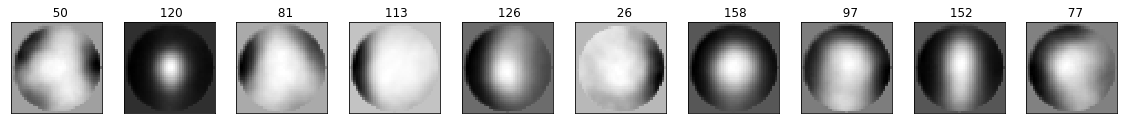

In [109]:
gen=filtered_images(smooth_threshold=0.35,reduce_res=False)
Reps,final_count=Kmeans(gen,n=10)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

 examples read=     16000     19  Prob=1.896364refine iteration  0, error=  0.335, n_Reps=   20
 examples read=     19000refine iteration  1, error=  0.221, n_Reps=   20
 examples read=     21000refine iteration  2, error=  0.218, n_Reps=   20
 examples read=     24000refine iteration  3, error=  0.213, n_Reps=   20
 examples read=     26000refine iteration  4, error=  0.216, n_Reps=   20


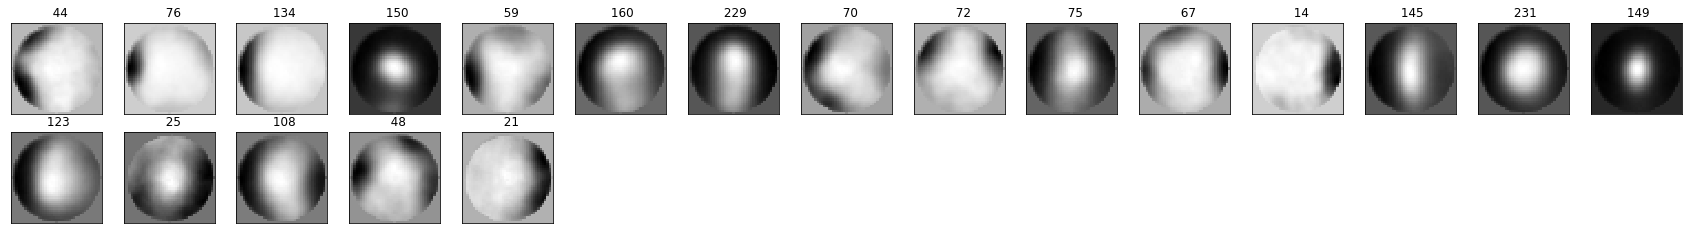

In [111]:
Reps,final_count=Kmeans(gen,n=20)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

 examples read=     31000     39  Prob=0.930909refine iteration  0, error=  0.305, n_Reps=   36
 examples read=     35000refine iteration  1, error=  0.208, n_Reps=   36
 examples read=     39000refine iteration  2, error=  0.202, n_Reps=   36
 examples read=     44000refine iteration  3, error=  0.201, n_Reps=   36
 examples read=     48000refine iteration  4, error=  0.200, n_Reps=   36


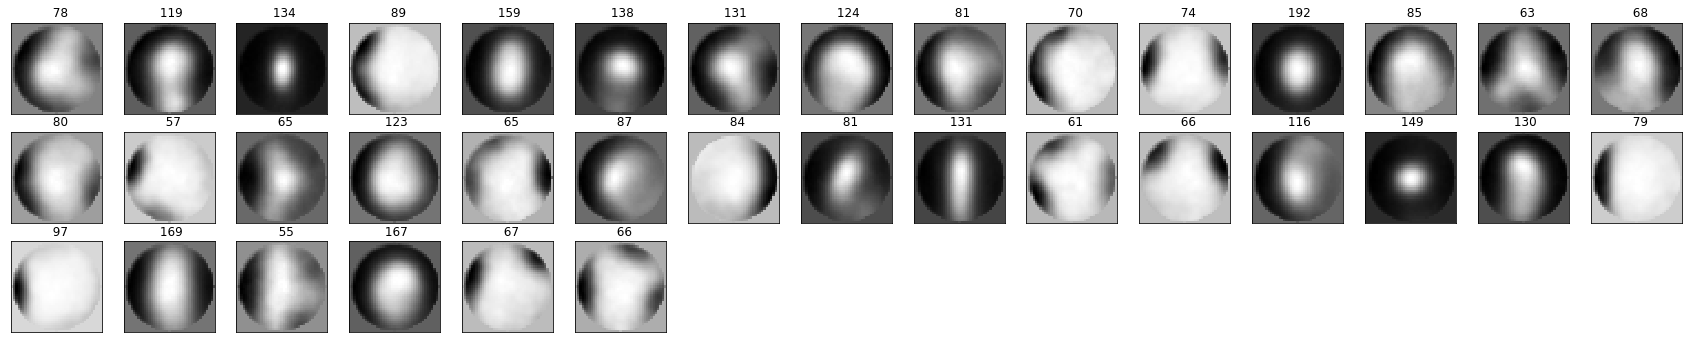

In [112]:
Reps,final_count=Kmeans(gen,n=40)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

 examples read=     57000     79  Prob=0.643182refine iteration  0, error=  0.281, n_Reps=   74
 examples read=     66000refine iteration  1, error=  0.195, n_Reps=   74
 examples read=     75000refine iteration  2, error=  0.190, n_Reps=   74
 examples read=     84000refine iteration  3, error=  0.188, n_Reps=   74
 examples read=     93000refine iteration  4, error=  0.187, n_Reps=   74


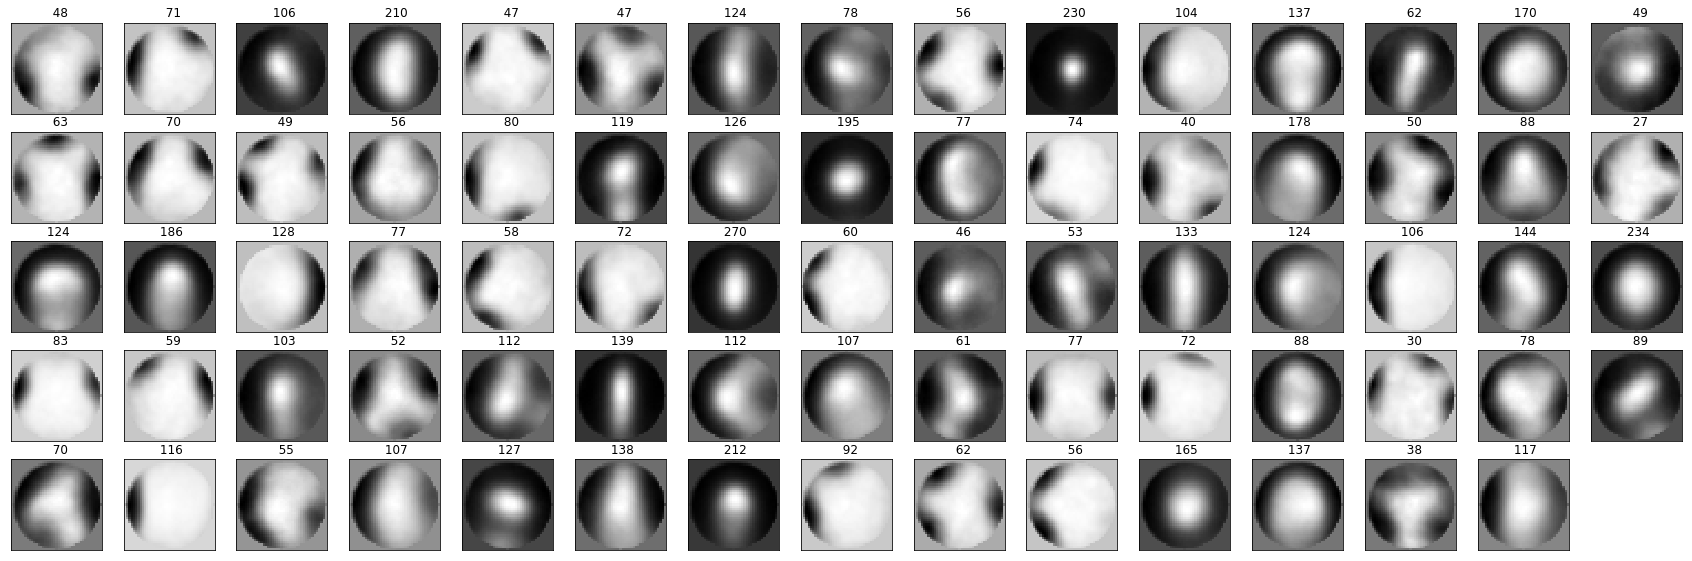

In [113]:
Reps,final_count=Kmeans(gen,n=80)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

 examples read=    112000    159  Prob=0.675909refine iteration  0, error=  0.256, n_Reps=  152
 examples read=    130000refine iteration  1, error=  0.182, n_Reps=  152
 examples read=    148000refine iteration  2, error=  0.176, n_Reps=  151
 examples read=      2000refine iteration  3, error=  0.175, n_Reps=  151
 examples read=     20000refine iteration  4, error=  0.175, n_Reps=  151


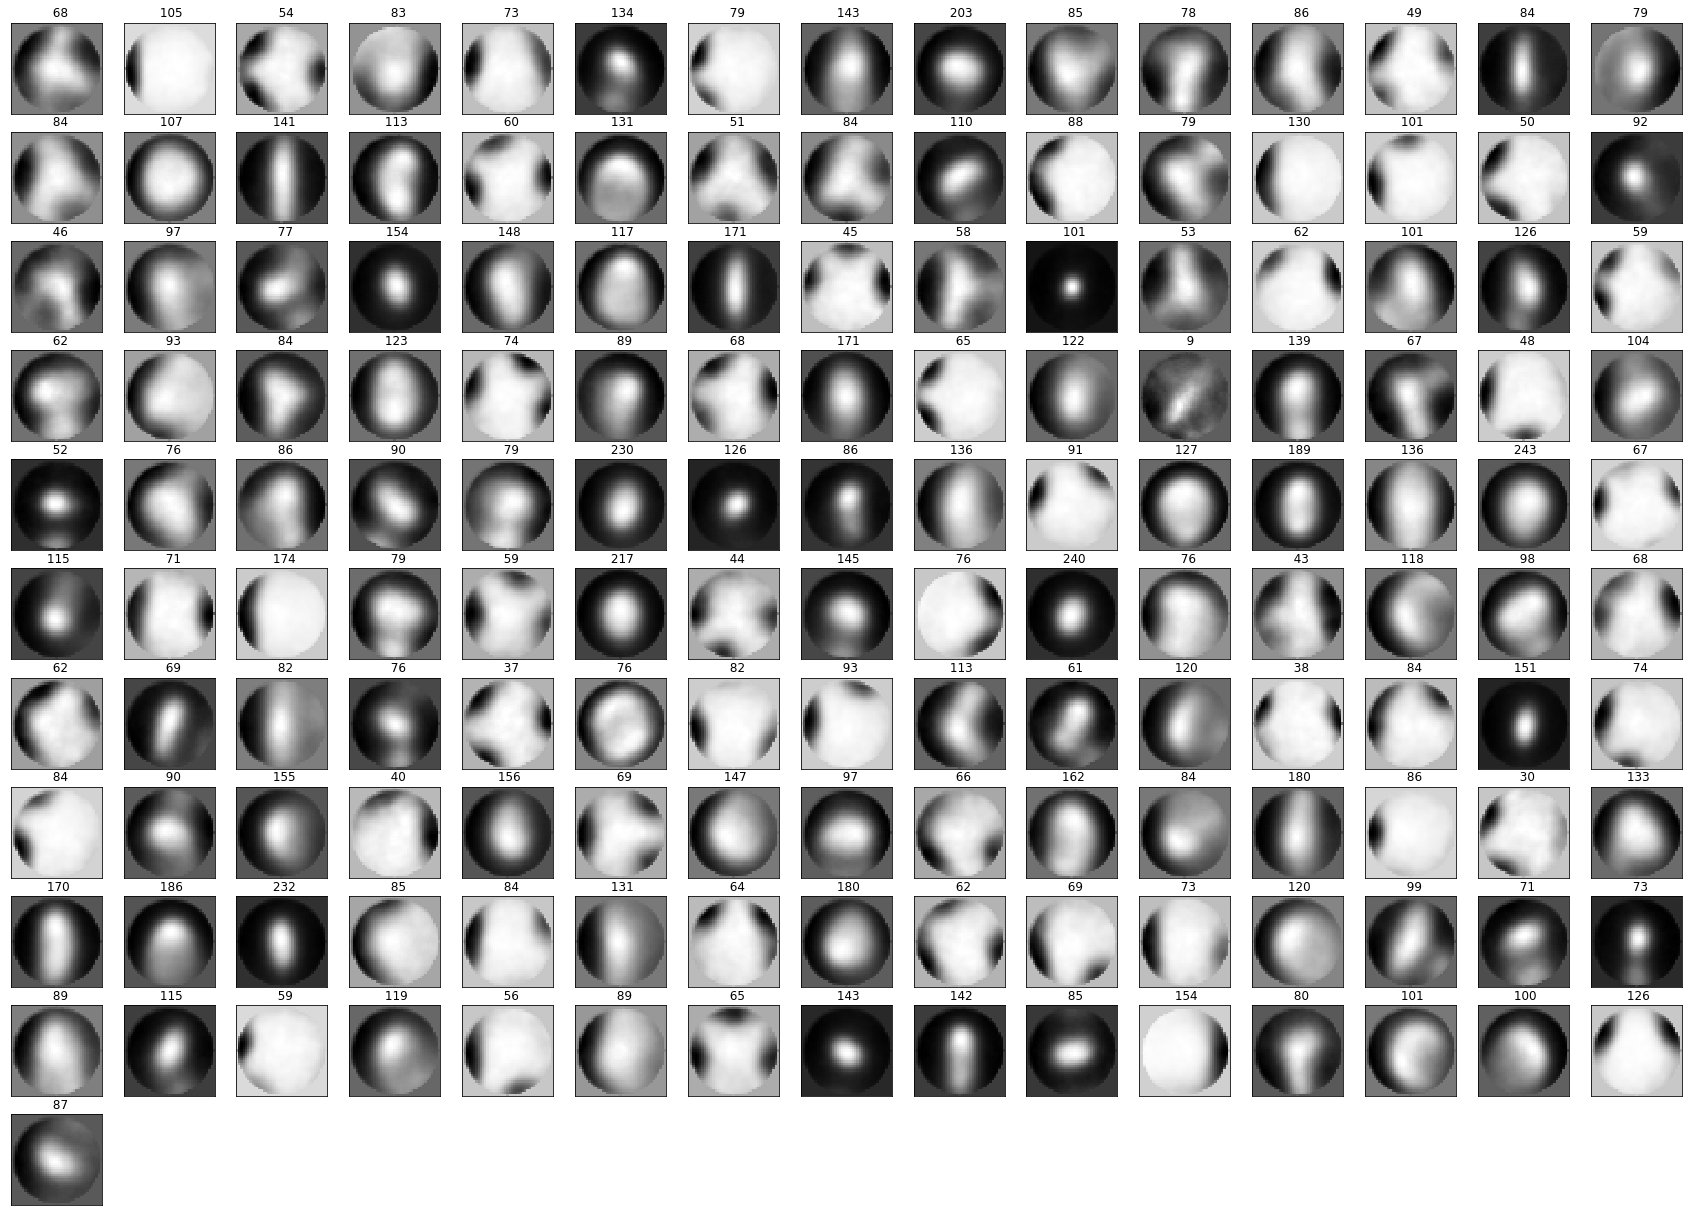

In [114]:
Reps,final_count=Kmeans(gen,Reps=[],n=160)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

 examples read=     59000    319  Prob=0.964545refine iteration  0, error=  0.238, n_Reps=  300
 examples read=     94000refine iteration  1, error=  0.173, n_Reps=  299
 examples read=    130000refine iteration  2, error=  0.168, n_Reps=  299
 examples read=    163000cmd= aws s3 cp s3://mousebraindata-open/MD657/permuted/permuted10.bin ../../data
 examples read=      2000refine iteration  3, error=  0.166, n_Reps=  299
 examples read=     37000refine iteration  4, error=  0.165, n_Reps=  299


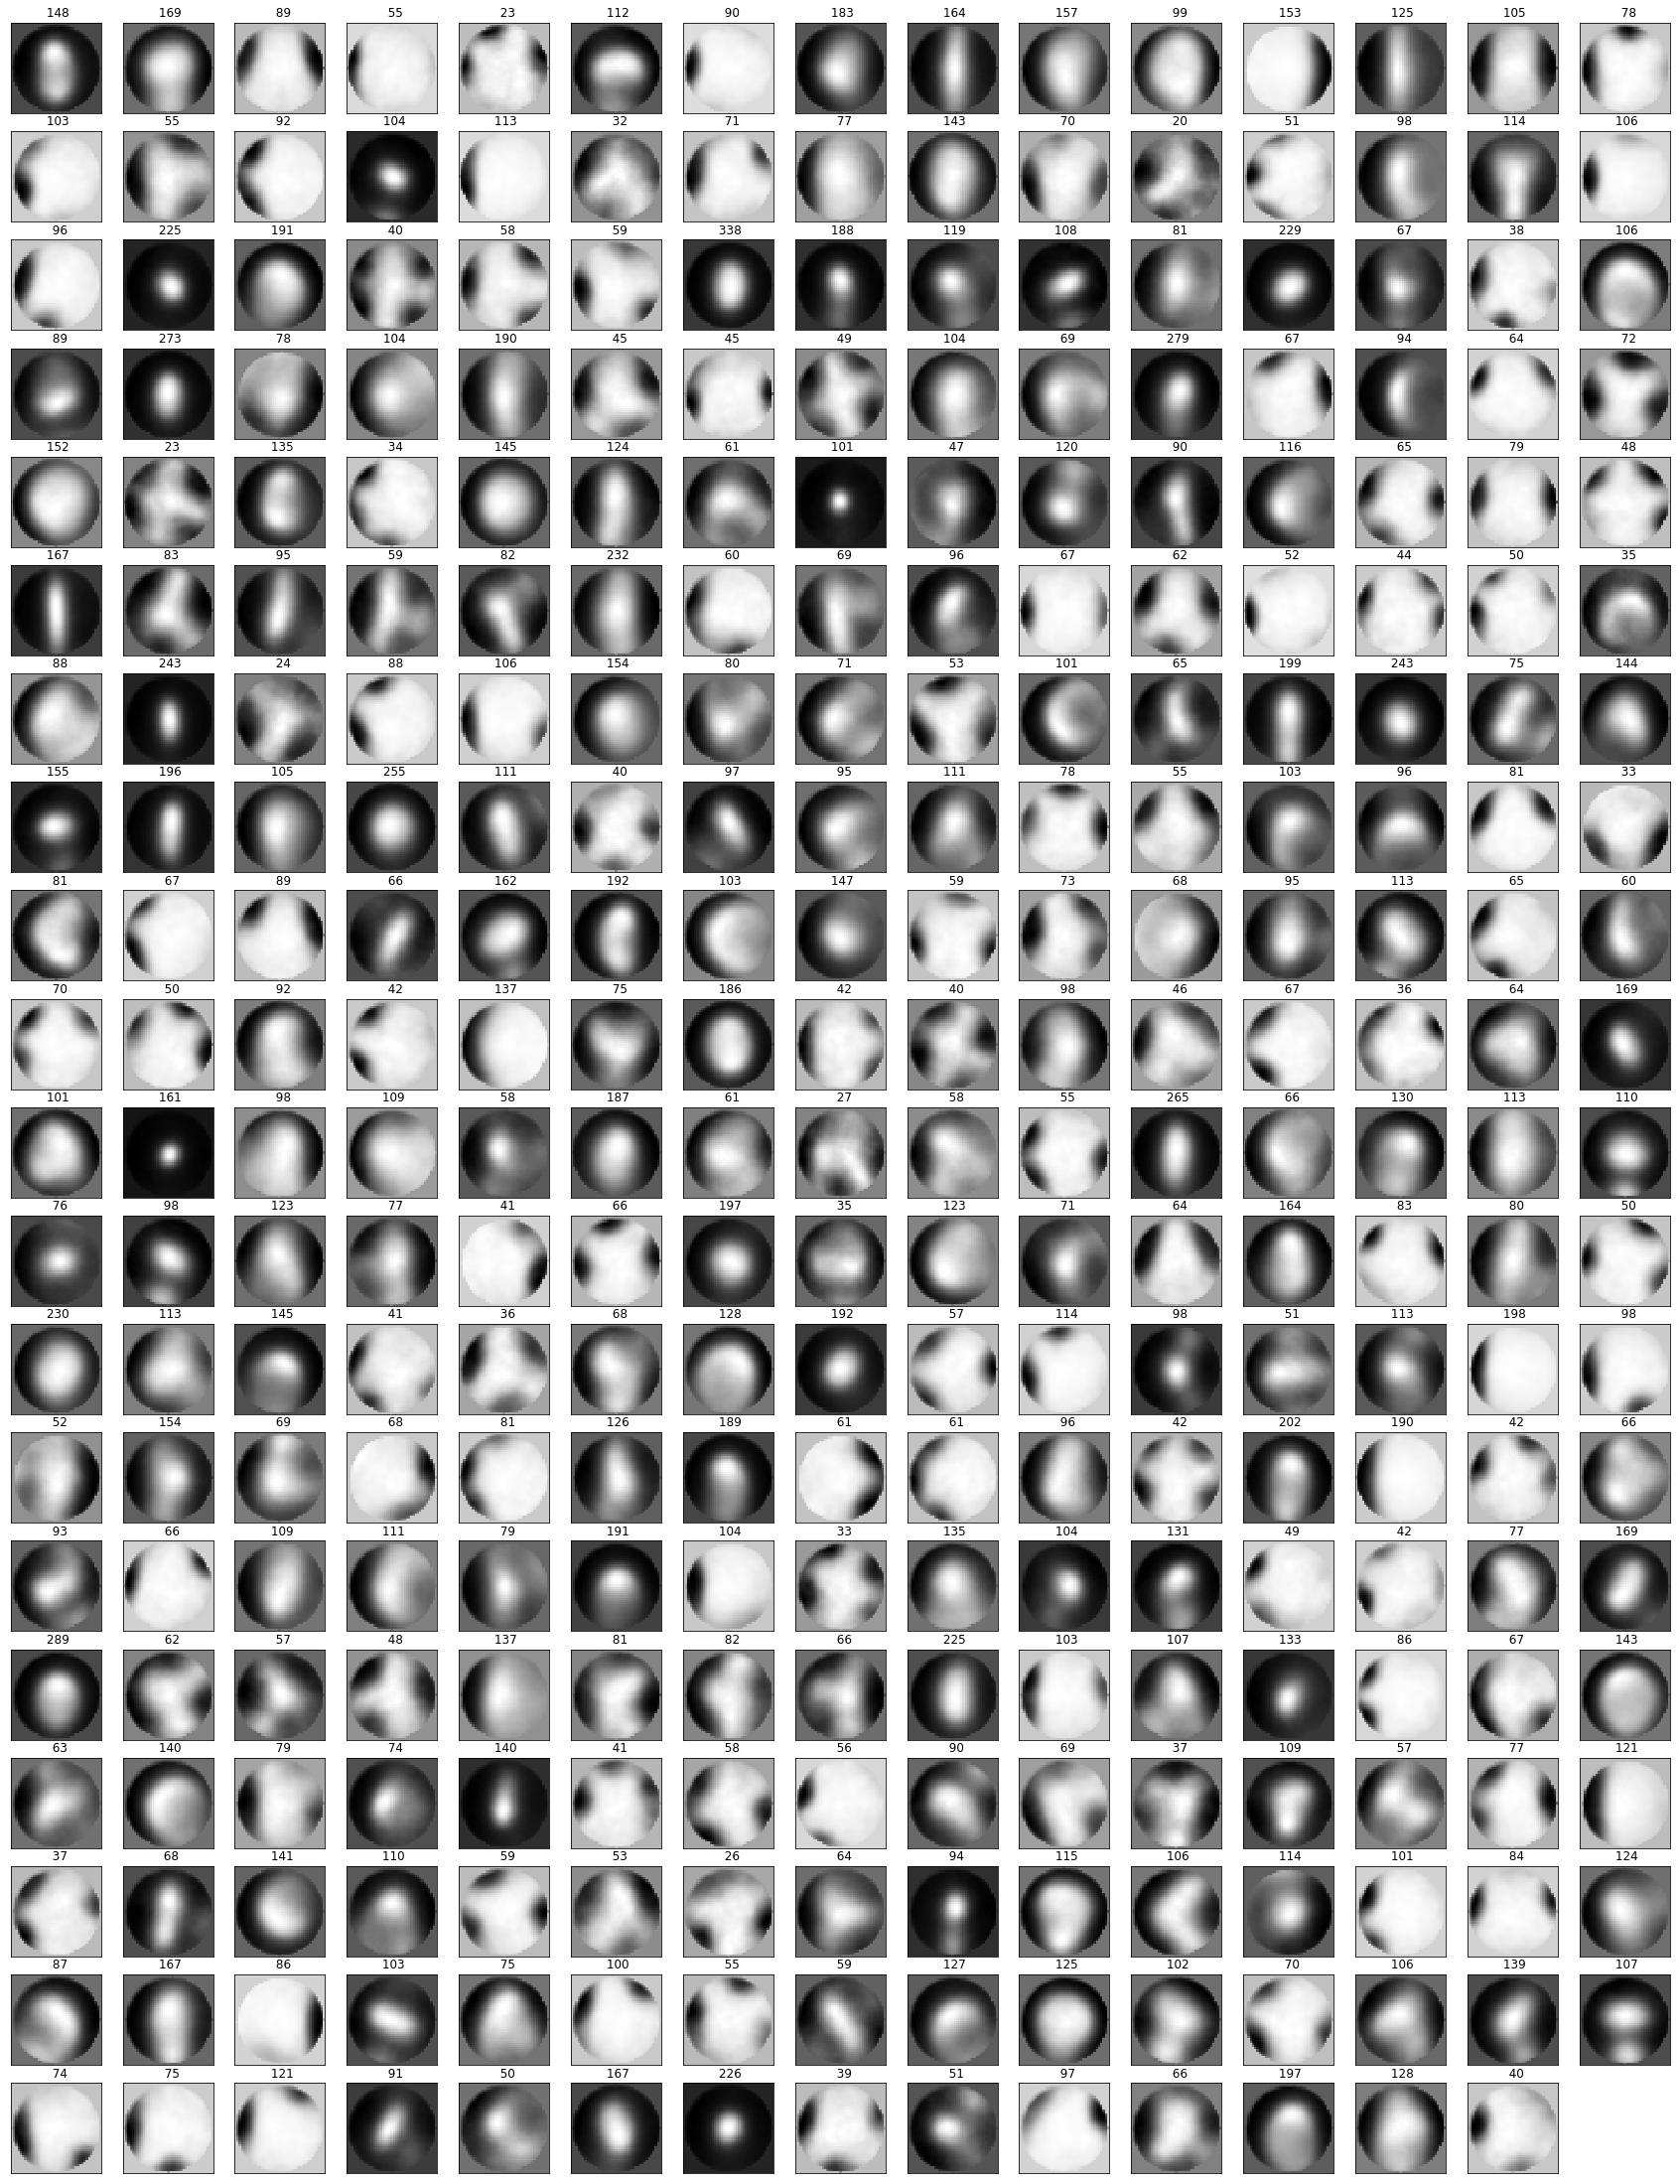

In [115]:
Reps,final_count=Kmeans(gen,Reps=[],n=320)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

In [46]:
g=filtered_images()
for i in range(10):
    pic=next(g)
    print(pic.shape,pic[10,10])

runPipe cmd= aws s3 ls s3://mousebraindata-open/MD657/permuted/ 
(21, 21) 1.05
(21, 21) 3.37
(21, 21) 1.013
(21, 21) 0.741
(21, 21) 2.516
(21, 21) 0.2446
(21, 21) 2.527
(21, 21) 0.9653
(21, 21) 1.851
(21, 21) 1.256


In [ ]:
#if __name__=="__main__"
N=300

Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

In [ ]:
for i in range(1,4):
    new_Reps,Reps_count,error = refineKmeans(lcombined[i*10000:(i+1)*10000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    plot_patches(Reps_mat,h=1,w=10,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
plot_patches(Reps_mat,h=10,w=10,_titles=['final_%4d'%x for x in Reps_count])

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['convolve']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
imshow(pic)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10586b400> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>